# Case de ML Insider

Os objetivos deste notebook são:

1. Explorar dados do Titanic, verficar tipos de dados (se estão faltando, quais eles são e como proceder para selecionar features mais significativas)
   1. Daqui poderemos desenvolver estrutura para validação de payloads com Pydantic
2. Desenvolver o processo de feature engineering
   1. Daqui poderemos desenvolver o pipeline que precisa ser colocado na endpoint de predição da API
3. Desenvolver pipeline de treinamento do modelo
   1. Daqui poderemos exportar modelo de IA oferecido pela API 

In [9]:
import sys
sys.path.append('..')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from app.custom_transformers import AloneFeatureCreator,AgeBinner

 

## Etapa 1



### Exploração dos dados

In [10]:
data = pd.read_csv("../data/Titanic-Dataset.csv")
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [12]:
data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


O dataset tem as seguintes variaveis:

- PassengerId (int): Id do passageiro, não vai ser importante para predições, vamos dropar ele

- Name (string): Nome do passageiro, vamos dropar

- Cabin (string) : Cabine do passageiro. Poderia ser útil pelo padrão do nome da cabine. Exemplo: C85, o C provavelmente é uma área do Titanic com uma localização espefica. Faz sentido chances de sobrevivencia serem afetadas por localidade mais próvavel do passageiro, mas como tem muitos dados nulos, vamos dropar também.

- Sex (string) :  Genero do passageiro. Faz sentido usar essa variavel. A evacuação de mulheres é priorizada em acidentes, especialemente se tiverem filhos. Como é variavel categorica, vamos fazer one-hot-enconding. Talvez seja possivel usar 0 para homem e 1 para mulher, nesse caso teria uma correlação positiva entre numero do gênero e sobrevivencia. Vamos explorar se realmente mais mulheres sobreviveram.

- Survived (int): Sobreviveu ou não (1 ou 0).

- Pclass (int): Significa classe economica do passageiro em que:
   - 1 = Classe mais alta
   - 2 = Classe média
   - 3 = Classe baixa
   São esses três apenas os valores possiveis, isso vai ser importante para validar o nosso payload. Isso provavelmente vai ter correlação negativa com survived então também vamos manter nesse formato.

- Age (float): Idade do passageiro. Importante mas pretendo categorizar em criança, adolescente, jovem, meia-idade e idoso (vamos plotar a distribuição para ver o que faz mais sentido). Tem alguns dados faltantes, podemos imputar a mediana neles para não perder essa info.  

- SibSp (int): Número de esposos e irmãos a bordo. Pode ser útil

- Parch (int): Número de pais e filhos a bordo. Pode ser combinado com SibSp para termos tamanho do grupo do passageiro 

- Fare: Quanto pagou na passagem. Parece ter muita relação com Pclass, mas podem ter passageiros de classe média ou baixa que juntaram dinheiro para pagar o ticket e por isso, estavam em posições mais seguras do titanic. Vamos manter essa variavel e verifcar distribuição dela para possiveis outliers.

- Embarked (string): Significa em porto o passageiro embarcou  (C = Cherbourg; Q = Queenstown; S = Southampton). Faz sentido dropar isso.

### Plano de ação

- A partir dessas análises, o plano agora é o seguinte:
1. Pipeline de processamento vai dropar PassengerId, Embarked, Name, Cabin

2. Verificar relação de genero de passageiro com survived para decidir melhor estratégia de codificação da string

3. Verificar distribuição de idade para ver quais categorias fazem sentido

4. Verificar relação de SibSp e Parch com survived e ver se podemos combiná-las

5. Verificar relação de fare com survived e Pclass (provalvelmente está bem correlacionado com fare)

6. Confirmar que PClass está associado com maiores chances de sobrevivência

### Vericação de relação de genero com chances de sobrevivencia

In [13]:
# Contagens absolutas
survival_counts = data.groupby(['Sex', 'Survived']).size().unstack(fill_value=0)
print("\nContagens:")
print(survival_counts)

# Calculo dos totais
row_totals = survival_counts.sum(axis=1)
print("\nTotais:")
print(row_totals)

# Divide each row by its total to get percentages
survival_percentages = survival_counts.div(row_totals, axis=0)
print("\nPorcentagens de sobrevivência")
print(survival_percentages)


Contagens:
Survived    0    1
Sex               
female     81  233
male      468  109

Totais:
Sex
female    314
male      577
dtype: int64

Porcentagens de sobrevivência
Survived         0         1
Sex                         
female    0.257962  0.742038
male      0.811092  0.188908


Essa análise confirma que mulheres sobreviveram bem mais que homens. Vamos usar 0 para male e 1 para female na codificação de variaveis categoricas.

### Exploração de relação idade com chances de sobrevivência

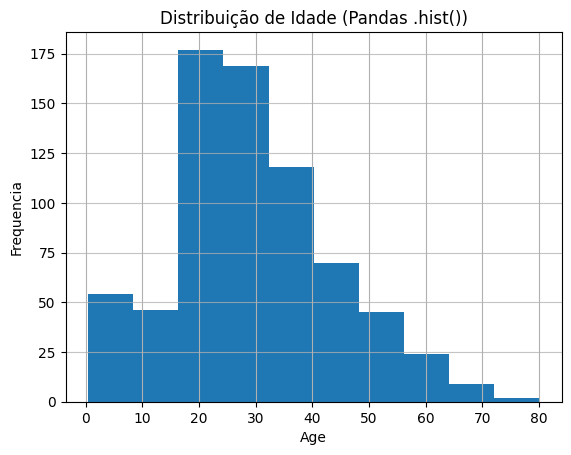

In [14]:
data['Age'].hist()
plt.title('Distribuição de Idade (Pandas .hist())')
plt.xlabel('Age')
plt.ylabel('Frequencia')
plt.grid(axis='y', alpha=0.75) 
plt.show() 

Parece que usar a mediana para imputar dados não é má ideia, vai assumir que o passageiro tem por volta de 30 anos. Olhando para o gráfico, parece fazer sentido dividir a idade em três grupos. Jovens entre 0 e 18, Adultos 18 e 50 e Idosos de 50 para cima. Vamos ver se isso tem relação com chance de sobrevivencia. 

In [15]:
# Faço uma cópia do dataframe para criar a coluna AgeGroup porque não quero alterar o anterior
df_copy = data.copy()



bins = [0, 18, 60, np.inf]
labels = ['0-18', '18-50', '50+']

df_copy['AgeGroup'] = pd.cut(df_copy['Age'], bins=bins, labels=labels, right=False)


#Contagens absolutas de sobrevivência
age_group_survival_counts = pd.crosstab(df_copy['AgeGroup'], df_copy['Survived'])
print("\n--- Contagem de Sobrevivência por AgeGroup ---")
print(age_group_survival_counts)

#Porcentagens de sobrevivência
age_group_survival_percentages = pd.crosstab(df_copy['AgeGroup'], df_copy['Survived'], normalize='index') * 100
print("\n--- Porcentagem de Sobrevivência por AgeGroup  ---")
print(age_group_survival_percentages.round(2))




--- Contagem de Sobrevivência por AgeGroup ---
Survived    0    1
AgeGroup          
0-18       52   61
18-50     353  222
50+        19    7

--- Porcentagem de Sobrevivência por AgeGroup  ---
Survived      0      1
AgeGroup              
0-18      46.02  53.98
18-50     61.39  38.61
50+       73.08  26.92


Por essa analise, temos alguns pontos:
- Tem poucas pessoas maiores de 50 anos, não faz sentido ter categoria idoso
- Pessoas menores de 18 anos sobreviveram mais percentualmente
Talvez faça sentido tratar idade como variavel binária (menor ou maior de 18 anos)

Vamos fazer um histograma por sobrevivência para confirmar

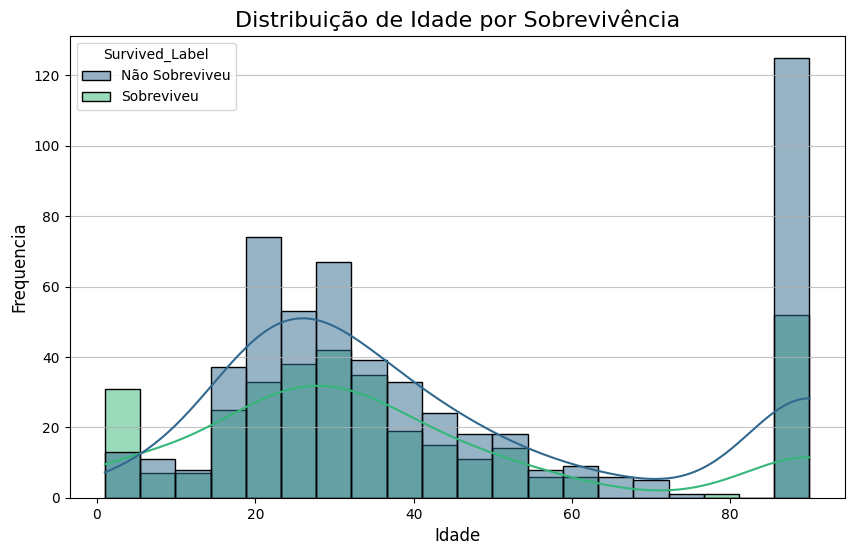

In [16]:
# Ensure 'Age' is within a reasonable range (e.g., 1 to 90)
data['Age'] = data['Age'].apply(lambda x: max(1, min(90, x)))

# Convert 'Survived' to a categorical label for better readability in the legend
data['Survived_Label'] = data['Survived'].map({0: 'Não Sobreviveu', 1: 'Sobreviveu'})


plt.figure(figsize=(10, 6)) # Set the figure size for better visualization
sns.histplot(data=data, x='Age', hue='Survived_Label', bins=20, kde=True, palette='viridis', common_norm=False)


plt.title('Distribuição de Idade por Sobrevivência', fontsize=16)
plt.xlabel('Idade', fontsize=12)
plt.ylabel('Frequencia', fontsize=12)

plt.grid(axis='y', alpha=0.75)

plt.show()

Baseado no histograma, decidi tranformar idade em binario como 1 para menor de 18 e 0 para maior de 18. Vamos usar mediana para imputar dados que faltam.

### Verificação de Fare com chances de sobrevivência

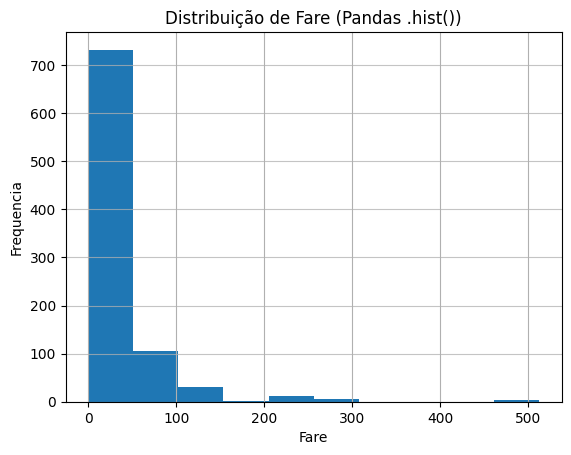

In [17]:
data['Fare'].hist()
plt.title('Distribuição de Fare (Pandas .hist())')
plt.xlabel('Fare')
plt.ylabel('Frequencia')
plt.grid(axis='y', alpha=0.75)
plt.show() 

In [18]:
data["Fare"].describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

Os outlier parecem mascarar os gráfico, temos que ajustar esse preço para inflação. Diferença entre 7 e 34 dolares,por exemplo pode ser significativa para época. Vamos plotar as diferenças retirando os valores acima de 100 dolares.

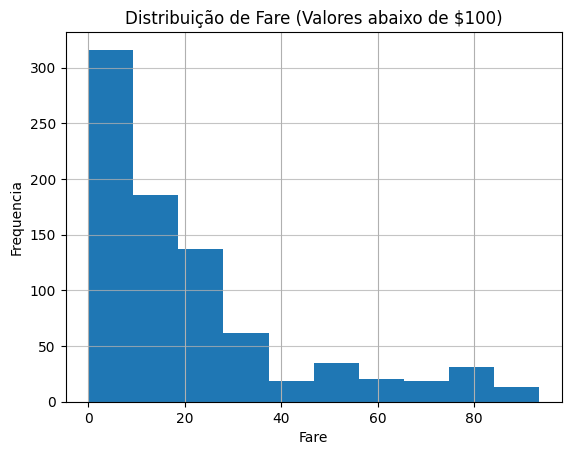

In [19]:
fare_below_100 = data[data['Fare'] < 100]['Fare']


fare_below_100.hist()
plt.title('Distribuição de Fare (Valores abaixo de $100)')
plt.xlabel('Fare')
plt.ylabel('Frequencia')
plt.grid(axis='y', alpha=0.75) 
plt.show() 

Realmente, tem uma distribuição mais enunciada entre 0 e 100. Vamos ver a relação de fare com survived. Deve ser melhor faz um box plot para isso.


/tmp/ipykernel_83514/2058424722.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='Survived_Label', y='Fare', palette='viridis')


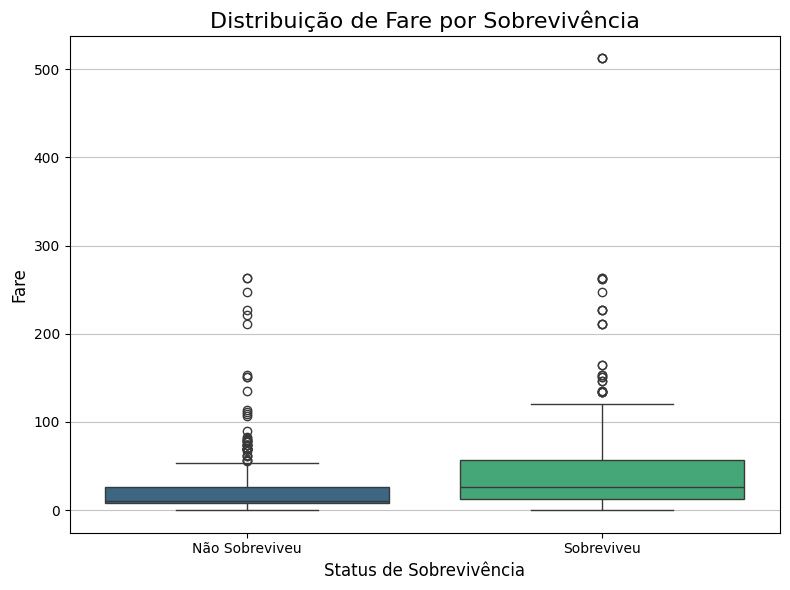

In [20]:

data['Fare'] = data['Fare'].apply(lambda x: max(0, x))


data['Survived_Label'] = data['Survived'].map({0: 'Não Sobreviveu', 1: 'Sobreviveu'})


plt.figure(figsize=(8, 6)) 
sns.boxplot(data=data, x='Survived_Label', y='Fare', palette='viridis')


plt.title('Distribuição de Fare por Sobrevivência', fontsize=16)
plt.xlabel('Status de Sobrevivência', fontsize=12)
plt.ylabel('Fare', fontsize=12)


plt.grid(axis='y', alpha=0.75)


plt.tight_layout()


plt.show()

Vou usar fare mesmo como variavel, acho interessante usar scaling para lidar com outliers. Vou usar o RobustScaler do sklearn, vai subtrair a mediana dos valores e dividir pelo IQR. Dá para usar QuantileTransformer também, mas como o objetivo do case não é performance do modelo, não vou explorar essa opção.

### Exploração de relação de sibsp e parch com chances de sobrevivência

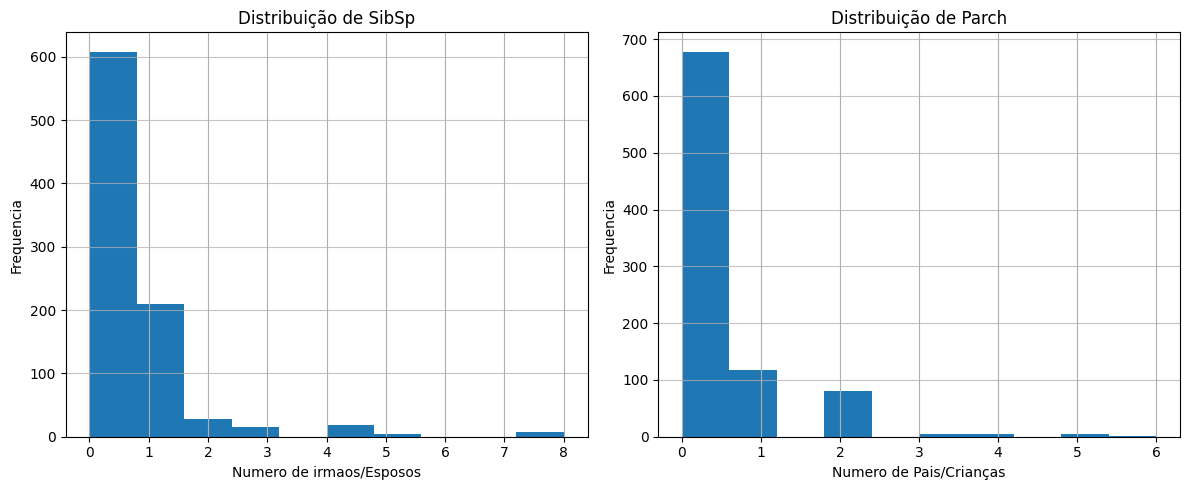

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

data['SibSp'].hist(ax=axes[0]) 
axes[0].set_title('Distribuição de SibSp')
axes[0].set_xlabel('Numero de irmaos/Esposos')
axes[0].set_ylabel('Frequencia')
axes[0].grid(axis='y', alpha=0.75)


data['Parch'].hist(ax=axes[1]) 
axes[1].set_title('Distribuição de Parch')
axes[1].set_xlabel('Numero de Pais/Crianças')
axes[1].set_ylabel('Frequencia')
axes[1].grid(axis='y', alpha=0.75)


plt.tight_layout()


plt.show()

Tem muita gente sozinha e não parece fazer sentido alto grau de diferenciação entre por exemplo entre alguém com 2 acompanhates ou 3. Vou simplificar essas informações. Vou somar as duas, se for 0, a pessoa tá sozinha e maior que 1, acompanhada. Depois for verificar qual a relação disso com sobrevivência.

In [22]:
df = data.copy()

df['FamilySize'] = df['SibSp'] + df['Parch'] 


df['IsAlone'] = np.where(df['FamilySize'] == 0, 'Alone', 'Not Alone')


is_alone_survival_counts = pd.crosstab(df['IsAlone'], df['Survived'])
print("\n--- Contagens de Sobrevivência por IsAlone ---")
print(is_alone_survival_counts)


is_alone_survival_percentages = pd.crosstab(df['IsAlone'], df['Survived'], normalize='index') * 100
print("\n--- Porcentagens de Sobrevivência  por IsAlone  ---")
print(is_alone_survival_percentages.round(2))


--- Contagens de Sobrevivência por IsAlone ---
Survived     0    1
IsAlone            
Alone      374  163
Not Alone  175  179

--- Porcentagens de Sobrevivência  por IsAlone  ---
Survived       0      1
IsAlone                
Alone      69.65  30.35
Not Alone  49.44  50.56


Vou usar essa abordagem mesmo, ela extrai mais significado das duas colunas

### Confirmação de relação de PClass com chances de sobrevivência

In [23]:
survival_counts = data.groupby(['Pclass', 'Survived']).size().unstack(fill_value=0)
print("\nContagens:")
print(survival_counts)

# Totais
row_totals = survival_counts.sum(axis=1)
print("\nTotais:")
print(row_totals)

# Porcentagens
survival_percentages = survival_counts.div(row_totals, axis=0)
print("\nPorcentagens:")
print(survival_percentages)


Contagens:
Survived    0    1
Pclass            
1          80  136
2          97   87
3         372  119

Totais:
Pclass
1    216
2    184
3    491
dtype: int64

Porcentagens:
Survived         0         1
Pclass                      
1         0.370370  0.629630
2         0.527174  0.472826
3         0.757637  0.242363


Confirmado!Pclass faz diferença

# Conclusões da Etapa 1 

- Concluimos que nossa pipeline de dados tem que fazer o seguinte:
  1. Dropar PassengerId, Nome, Ticket, Cabin e Embarked

  2. A coluna de genero do passageiro tem que vai codificar male em 0 e female em 1
  
  3. A coluna de idade vai dividir passageiros em grupos de menores que 18 e maiores que 18
  
  4. A coluna Fare vai passar por scaling usando RobustScaler
  
  5. As colunas SibSp e Parch serão somadas e convertidas em categorias Alone (0) e Not Alone (1)

- Antes de treinar modelo, imputaremos a mediana para a idades faltantes

# Etapa2

## Plano da Etapa 2

1. Criar Custom Transformers para montar Pipeline do Sklearn

2. Preparar dados de treinamento e validação

3. Criar pipeline de treinamento

4. Treinar modelos e logar experimentos no Mlflow.

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin

### Criação de Custom Transformers

In [25]:
# class AgeBinner(BaseEstimator, TransformerMixin):
#     def fit(self, X, y=None):
#         return self
#     def transform(self, X):
#         return (X <= 18).astype(int)

# class AloneFeatureCreator(BaseEstimator, TransformerMixin):
#     def fit(self, X, y=None):
#         return self
#     def transform(self, X):
#         X_copy = X.copy()
#         X_copy['Alone'] = (X_copy['SibSp'] + X_copy['Parch'] == 0).astype(int)
#         X_copy = X_copy.drop(columns=['SibSp', 'Parch']) 
#         return X_copy

Esses custom transformers foram movidos para o diretório do app por uma questão de contexto do joblib na criação do docker, agora eles são importados do app.custom_transformers

### Preparação de dados de treinamento

In [26]:
dados = pd.read_csv("../data/Titanic-Dataset.csv")

#Imputar mediana em dados que faltam, fazemos isso antes do split para evitar data leakage
age_median = dados['Age'].median()
dados['Age'] = dados['Age'].fillna(age_median)

dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Todos os dados que vamos usar estão completos (891 valores)

In [27]:
# Divisão dos dados de treinamento e teste 
X = dados.drop('Survived', axis=1)
y = dados['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Preparo do pipeline de pré processamento

In [28]:
# Transformador numerico para escalar fare
numerical_transformer = Pipeline(steps=[
    ('scaler', RobustScaler())
])

# Transformador categorico para genero
categorical_transformer = Pipeline(steps=[
    ('encoder', OrdinalEncoder(categories=[['male', 'female']])) 
])

# Tranformador para Idade 
age_transformer = Pipeline(steps=[
    ('age_binner', AgeBinner())
])


# Full pipeline de preprocessamento
data_preprocessing_pipeline = Pipeline(steps=[
    ('alone_feature_creator', AloneFeatureCreator()), # Cria coluna Alone e dropa SibSp e Parch
    ('column_transformer', ColumnTransformer(
        transformers=[
            ('drop_cols', 'drop', ['Name', 'Cabin', 'Embarked', 'PassengerId','Ticket']), # Dropa colunas desnecessárias
            ('sex_encode', categorical_transformer, ['Sex']),
            ('age_bin', age_transformer, ['Age']),
            ('fare_scale', numerical_transformer, ['Fare'])
        ],
        remainder='passthrough' # Passa o resto
    ))
])

### Inclusão de modelos no pipeline e treinamento com mlflow

In [29]:
import mlflow
import mlflow.sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from mlflow.models import infer_signature
import os
import joblib

In [30]:
models = {
    "LogisticRegression": LogisticRegression(random_state=42, solver='liblinear'), # Added solver for clarity
    "RandomForestClassifier": RandomForestClassifier(random_state=42, n_estimators=100),
    "XGBoostClassifier": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss') # Suppress warning
}


mlflow.set_tracking_uri("file:./mlruns")
mlflow.set_experiment("Titanic Survival Prediction - Multi-Model")


output_dir = "../saved_models"
os.makedirs(output_dir, exist_ok=True)

for model_name, model_instance in models.items():
    with mlflow.start_run(run_name=f"{model_name}_Experiment"):
        print(f"\n--- Processando modelo: {model_name} ---")

        # Combina pipeline de processamento de dados com classificador
        model_pipeline = Pipeline(steps=[
            ('preprocessor', data_preprocessing_pipeline),
            ('classifier', model_instance)
        ])

        # Treina o modelo
        model_pipeline.fit(X_train, y_train)
        print(f" Treinamento completo")

        # --- Export dos modelos para a API ---
        joblib_path = os.path.join(output_dir, f"{model_name}.joblib")
        joblib.dump(model_pipeline, joblib_path)
        print(f"Modelo exportado com sucesso para: {joblib_path}")

        
        y_pred = model_pipeline.predict(X_test)
        
        
        metrics = {
            "accuracy": accuracy_score(y_test, y_pred),
            "precision": precision_score(y_test, y_pred),
            "recall": recall_score(y_test, y_pred),
            "f1_score": f1_score(y_test, y_pred)
        }
        
        
        mlflow.log_params(model_instance.get_params())
        mlflow.log_metrics(metrics)
        print(f"Metricas disponiveis no MLFlow: {metrics}")

        # --- Export de exemplo de input para o mlflow ---
        input_example = X_train.iloc[[0]]
        signature = infer_signature(input_example, model_pipeline.predict(input_example))
        
        mlflow.sklearn.log_model(
            sk_model=model_pipeline,
            artifact_path=f"{model_name}_model",
            signature=signature,
            input_example=input_example
        )
        print(f"Artefato do modelo carregado com sucesso para MLflow com Run ID: {mlflow.active_run().info.run_id}")

print("\n--- Todas as runs e exports realizados com sucesso ---")

/home/fu2re/Documents/titanic_api/venv/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/fu2re/Documents/titanic_api/venv/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/fu2re/Documents/titanic_api/venv/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement 


--- Processando modelo: LogisticRegression ---
 Treinamento completo
Modelo exportado com sucesso para: ../saved_models/LogisticRegression.joblib
Metricas disponiveis no MLFlow: {'accuracy': 0.7988826815642458, 'precision': 0.7878787878787878, 'recall': 0.7027027027027027, 'f1_score': 0.7428571428571429}


/home/fu2re/Documents/titanic_api/venv/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/fu2re/Documents/titanic_api/venv/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


Artefato do modelo carregado com sucesso para MLflow com Run ID: 32c25d73fbc94b158c83f42ab77a51c5

--- Processando modelo: RandomForestClassifier ---
 Treinamento completo
Modelo exportado com sucesso para: ../saved_models/RandomForestClassifier.joblib
Metricas disponiveis no MLFlow: {'accuracy': 0.8100558659217877, 'precision': 0.7857142857142857, 'recall': 0.7432432432432432, 'f1_score': 0.7638888888888888}


/home/fu2re/Documents/titanic_api/venv/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/fu2re/Documents/titanic_api/venv/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlf

Artefato do modelo carregado com sucesso para MLflow com Run ID: 36b3565d987849fb820aeaa507a1fc66

--- Processando modelo: XGBoostClassifier ---


/home/fu2re/Documents/titanic_api/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [12:33:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/fu2re/Documents/titanic_api/venv/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/fu2re/Documents/titanic_api/venv/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/fu2re/Documents/titanic_api/venv/lib/python3.12/site-packages/mlflow/types/utils.py:4

 Treinamento completo
Modelo exportado com sucesso para: ../saved_models/XGBoostClassifier.joblib
Metricas disponiveis no MLFlow: {'accuracy': 0.8212290502793296, 'precision': 0.7916666666666666, 'recall': 0.7702702702702703, 'f1_score': 0.7808219178082192}
Artefato do modelo carregado com sucesso para MLflow com Run ID: ce75cec6b9dd4337adb820f5950b9349

--- Todas as runs e exports realizados com sucesso ---


/home/fu2re/Documents/titanic_api/venv/lib/python3.12/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
